# Run this cell

#### To do:
 - Try doing HP, Rect, LP and compare to the other method. 
 - What does the new frequencies mean? Can they be used to look for interesting frequencies?
 - Compare the first and last intervals. Spectral kurtosis development? Did they do that in the paper I am thinking of? 

In [251]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
import sys, os
from numpy import savez_compressed



ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
print("ROOT", ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/utils/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

import functions as f

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)

module_path = os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/"))
if module_path not in sys.path:
    print("appended")
    sys.path.append(module_path)


%autoreload
import wt_data
import ff_transform
import explore_fft_time_data
import filters


ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


# Run from here

In [3]:
COMPONENT_NAME = 'GbxHssRr'
# ['GbxHssRr;0,0102;m/s2']

In [14]:
wt_instance = wt_data.load_instance('WTG04', load_minimal=False)


Loading WTG04...
Loaded WTG04


In [17]:
# Need only run once!

def load_wt(wt_name,component_name):
    #wt_instance = wt_data.load_instance(wt_name, load_minimal=False)
    intervals_vibrations = []
    intervals_times = []
    intervals_data = []
    number_of_intervals = len(wt_instance.ten_second_intervals)
    intervals_peak_array = []
    
    for i, interval in enumerate(wt_instance.ten_second_intervals):
        if (interval.sensor_df.shape[1]) == 14 and (interval.op_df["PwrAvg;kW"][0] > 0):
            rot_data = interval.high_speed_rot_data

            avg_speed = rot_data['mean']
            avg_power = interval.op_df["PwrAvg;kW"][0]
            active_power = interval.op_df["PwrAct;kW"][0]
            wind_speed = interval.op_df["WdSpdAct;m/s"][0]
            nacelle_direction = interval.op_df["NacDirAct;deg"][0]
            
            interval_data = []
            interval_data.append(avg_power)
            interval_data.append(active_power)
            interval_data.append(wind_speed)
            interval_data.append(nacelle_direction)
            
            # Extract logging of each rotation
            peak_array = interval.high_speed_peak_array
            intervals_peak_array.append(peak_array)
            
            # Vibration signal and timestamps
            vibration_signal = interval.sensor_df[component_name]
            time_stamps = interval.sensor_df['TimeStamp']
            time = interval.sensor_df['TimeStamp']

            intervals_vibrations.append(vibration_signal)
            intervals_times.append(time)
            intervals_data.append(interval_data)
            
    df_column_names = ['AvgPower',
                       'ActPower',
                       'WindSpeed',
                       'NacelleDirection']
    
    df_intervals_data = pd.DataFrame(intervals_data, columns=df_column_names)
            
    return intervals_vibrations, intervals_times, df_intervals_data, intervals_peak_array




# Select WT and component

In [20]:
intervals_vibrations_wt4, intervals_times_wt4, df_intervals_data_wt04, intervals_peak_array_wt04 = load_wt(
    "WTG04",
    'GbxHssRr;0,0102;m/s2')

In [21]:
# Saving vibrations
savez_compressed('../../sensor_data/intervals_vibrations_wt04.npz', intervals_vibrations_wt4)
print(f'1. Saved vibrations')

# Saving timestamps
savez_compressed('../../sensor_data/intervals_times_wt04.npz', intervals_times_wt4)
print(f'2. Saved timestamps')

# Saving operating data
df_intervals_data_wt04.to_csv('../../sensor_data/df_intervals_data_wt04.csv.gz', compression='gzip')
print(f'3. Saved operating data')

# Saving rotation data
savez_compressed('../../sensor_data/intervals_peak_array_wt04.npz', intervals_peak_array_wt04)
print(f'4. Saved rotation data')

del intervals_vibrations_wt4, intervals_times_wt4, df_intervals_data_wt04#, intervals_peak_array_wt04
print(f'5. Deleted python variables')

1. Saved vibrations
2. Saved timestamps
3. Saved operating data
4. Saved rotation data
5. Deleted python variables


In [24]:
# Load compressed data
from numpy import load
df_intervals_data_wt04 = pd.read_csv('../../sensor_data/df_intervals_data_wt04.csv.gz', compression='gzip')
vib_signal_wt4 = load('../../sensor_data/intervals_vibrations_wt04.npz')
times_wt4 = load('../../sensor_data/intervals_times_wt04.npz')
peak_array_wt04 = load('../../sensor_data/intervals_peak_array_wt04.npz', allow_pickle=True)

In [25]:
vib_signal_wt4 = vib_signal_wt4['arr_0']
times_wt4 = times_wt4['arr_0']
peak_array_wt04 = peak_array_wt04['arr_0']

In [26]:
print(vib_signal_wt4.shape)
print(df_intervals_data_wt04.shape)
print(times_wt4.shape)
print(peak_array_wt04.shape)

(424, 262144)
(424, 5)
(424, 262144)
(424,)


In [27]:
from scipy import stats
stats.describe(vib_signal_wt4[2])

DescribeResult(nobs=262144, minmax=(1140.154670267, 1254.097433651), mean=1197.8798405171483, variance=156.36851298741024, skewness=-0.012513486195968326, kurtosis=0.03141294128650163)

5
110886912


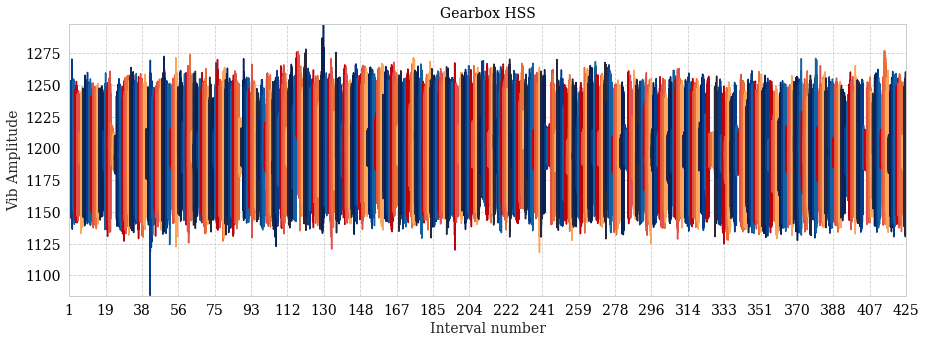

In [28]:
def plot_vib_consecutive(down):
    indexes = []
    index_start=0
    fig, ax = plt.subplots(figsize=(15,5))
    for i, d in enumerate(down):
        indexes.append(index_start)
        index_end = len(d)
        x = np.arange(index_start, index_start+index_end)
        index_start = len(x) + index_start
        plt.plot(x,d)
        plt.margins(0)
    print(len(np.linspace(0,index_start+index_end,5)))
    plt.xticks(np.linspace(0,index_start,24),[int(round(elem)) for i,elem in enumerate(np.linspace(1,len(down)+1,24))])
    #locs, labels = plt.xticks()
    #ax.set_xticks(indexes)
    #ax.set_xticklabels(np.arange(1,len(indexes)+1))
    # plt.xticks(fontsize=7, rotation=90)
    print((indexes[-1]))
    plt.title("Gearbox HSS")
    plt.xlabel("Interval number")
    plt.ylabel("Vib Amplitude")
    plt.show()
plot_vib_consecutive(vib_signal_wt4)

# Bandpass method (Bandpass + RECT)

In [29]:
def get_sampling_freq(signal,times):
    for i in range(len(np.array(times))):
        times = np.array(times)
        T = times[0] - times[1]
        ending_time = np.array(times)[-1]
        N = len(signal)
        fs = N/ending_time
        break
    return fs, N, T, ending_time

In [30]:
def perform_fft(amplitudes, timestamps,plot=False ):
    t = timestamps
    sig = amplitudes
    mean_amplitude = np.mean(sig)
    sig = sig - mean_amplitude  # Centering around 0
    fft = np.fft.fft(sig)
    N = sig.size
    T = t[1] - t[0]

    f = np.linspace(0, 1 / T, N, )  # start, stop, number of. 1 / T = frequency is the biggest freq

    f = f[:N // 2]
    y = np.abs(fft)[:N // 2]
    y_norm = np.abs(fft)[:N // 2] * 1 / N  # Normalized
    fft_modulus_norm = y_norm
    fft_obj = {'freq':f,'fft_norm': fft_modulus_norm}
    return fft_obj

## Butter bandpass

In [31]:
from scipy.signal import butter, lfilter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [67]:
%autoreload
import resample

## Perform envelope process

In [197]:
def perform_envelope_process(timestamps, interval_signal, peak_array, 
                             COMPONENT_NAME, lowcut,highcut,
                             highcut_lowpass, order = 5,
                             plot_low=60,plot_high=800,plot=False,
                             resample_original=False, resample_last=False,
                             square=False):
    
     # Resampling original signal
    if resample_original:
        _,_, order_resap, amplitude_resamp, time_resamp = resample.cubic_interpolation_resampling(
            timestamps, 
            interval_signal, 
            peak_array, 
            round_plots=4, 
            plotting=False,
            number_of_resample_points=2000
        )
        timestamps = time_resamp
        interval_signal = amplitude_resamp
        

    
    fs, _, _ ,_ =  get_sampling_freq(interval_signal,timestamps)
    bandpass_filtered = butter_bandpass_filter(interval_signal,lowcut, highcut, fs, order=5)
    bandpass_filtered_rect = abs(bandpass_filtered)
    if square:
        bandpass_filtered_rect = bandpass_filtered_rect**2
    
    # Adding lowpass filter
    bandpass_filtered_rect_lp = butter_lp_filter(bandpass_filtered_rect, highcut_lowpass, fs, order=5)
    
    # Add all filtered signals to an array
    all_time_signals = [interval_signal, bandpass_filtered, bandpass_filtered_rect, 
                        bandpass_filtered_rect_lp]
    
    if resample_last and resample_original:
        print('Cannot resample both original and last signal!')
        return

    # Resampling last signal
    elif resample_last:
        _,_, resampled_order, resampled_amplitude, resampled_time = resample.cubic_interpolation_resampling(
            timestamps, 
            bandpass_filtered_rect_lp, 
            peak_array, 
            round_plots=4, 
            plotting=False,
            number_of_resample_points=2000
        )
        all_time_signals.append(resampled_amplitude)
        
    # Do fft of the different filtered vibration signals
    all_fft_spectrums = [perform_fft(sig,timestamps) for i, sig in enumerate(all_time_signals)]

    if plot:
        if resample_last:
            plot_enveloping_process(5,2,COMPONENT_NAME, all_time_signals,all_fft_spectrums, 
                                    timestamps,lowcut,highcut, highcut_lowpass, resampled_time)
        else:
            plot_enveloping_process(4,2,COMPONENT_NAME, all_time_signals,all_fft_spectrums, 
                                    timestamps,lowcut,highcut, highcut_lowpass)
        
        start_index = np.where(timestamps >= 0.025)[0][0]
        end_index = np.where(timestamps >= 0.05)[0][0]
            
        df = pd.DataFrame(interval_signal)
        df['timestamp'] = timestamps
        # df.plot.hist(bins=2000)
        df.iloc[start_index:end_index].plot.line(x='timestamp',y=0,title="Zoomed in on raw signal: Index 60 to 800",legend=False,figsize=(10,2))
        
        df = pd.DataFrame(bandpass_filtered)
        df['timestamp'] = timestamps
        # df.plot.hist(bins=2000)
        df.iloc[start_index:end_index].plot.line(x='timestamp',y=0,title="Zoomed in after bandpass: Index 60 to 800 ",legend=False,figsize=(10,2))

        df = pd.DataFrame(bandpass_filtered_rect)
        df['timestamp'] = timestamps
        # df.plot.hist(bins=2000)
        df.iloc[start_index:end_index].plot.line(x='timestamp',y=0,title=f"Zoomed in after rectification: {plot_low} to {plot_high}",legend=False,figsize=(10,2))


        df = pd.DataFrame(bandpass_filtered_rect_lp)
        df['timestamp'] = timestamps
        # df.plot.hist(bins=2000)
        df.iloc[start_index:end_index].plot.line(x='timestamp',y=0,title=f"Zoomed in after lowpass: Index {plot_low} to {plot_high}",legend=False,figsize=(10,2))

        if resample_last:
            start_index = np.where(resampled_time >= 0.025)[0][0]
            end_index = np.where(resampled_time >= 0.05)[0][0]
            print(start_index)
            fig,ax = plt.subplots(figsize=(10,2))
            ax.set_title('Resampled Signal')
            ax.plot(resampled_time[start_index:end_index], resampled_amplitude[start_index:end_index])
            ax.set_xlim(resampled_time[start_index], resampled_time[end_index])
        plt.show()
    return all_time_signals, all_fft_spectrums

## Plot enveloping process

In [198]:
def plot_enveloping_process(rows, cols, COMPONENT_NAME, all_time_signals, all_fft_spectrums, 
                            timestamps, lowcut, highcut, highcut_lowpass, resampled_time=[]):
    fig, ax = plt.subplots(rows, cols,figsize=(15,10))
    fig.suptitle(f'{COMPONENT_NAME}: Envelop signal processing ',fontsize=16, y=1.05)

    # Row 1
    ax[0,0].plot(timestamps,all_time_signals[0])
    ax[0,0].set_title(f"Raw vibration signal from {COMPONENT_NAME} ")
    ax[0,1].plot(all_fft_spectrums[0]['freq'],all_fft_spectrums[0]['fft_norm'])
    ax[0,1].set_xlabel("Frequency [Hz]")
    ax[0,1].set_title(f"FFT of raw signal from {COMPONENT_NAME}")

    # Row 2
    ax[1,0].plot(timestamps,all_time_signals[1])
    ax[1,0].set_title(f'filtered signal with lower cutoff {lowcut} and higher {highcut} Hz')
    ax[1,1].plot(all_fft_spectrums[1]['freq'],all_fft_spectrums[1]['fft_norm'])
    ax[1,1].set_xlabel("Frequency [Hz]")
    ax[1,1].set_xlim(lowcut-500,highcut+500)
    
    # Row 3
    ax[2,0].plot(timestamps,all_time_signals[2])
    ax[2,0].set_title(f'Rectified the bandpass-filtered signal')
    ax[2,1].plot(all_fft_spectrums[2]['freq'],all_fft_spectrums[2]['fft_norm'])
    ax[2,1].set_xlabel("Frequency [Hz]")
    ax[2,1].margins(0)
    # ax[2,1].set_xlim(0,1000)    

    # Row 4
    ax[3,0].plot(timestamps,all_time_signals[3])
    ax[3,0].set_title(f'With final lowpass filter added')
    ax[3,1].plot(all_fft_spectrums[3]['freq'],all_fft_spectrums[3]['fft_norm'])
    ax[3,1].set_xlabel("Frequency [Hz]")
    ax[3,1].set_xlim(0,2000)
    
    # Row 5
    if rows > 4:
        ax[4,0].plot(resampled_time, all_time_signals[4])
        ax[4,0].set_title(f'Resampled Signal')
        ax[4,1].plot(all_fft_spectrums[4]['freq'],all_fft_spectrums[4]['fft_norm'])
        ax[4,1].set_title(f'FFT of Resampled Signal')
        ax[4,1].set_xlabel("Frequency [Hz]")
        ax[4,1].set_xlim(0,highcut_lowpass)
    
    plt.tight_layout()
    plt.margins(0)
    plt.show()

## Select lowcut and highcut

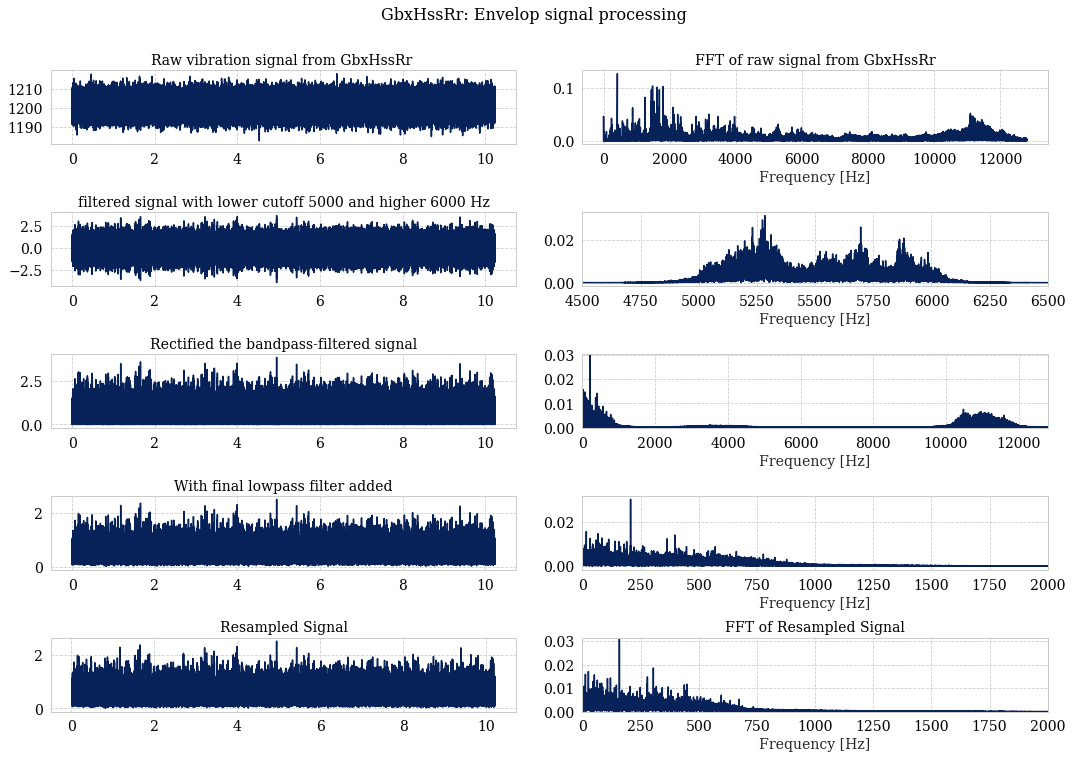

32


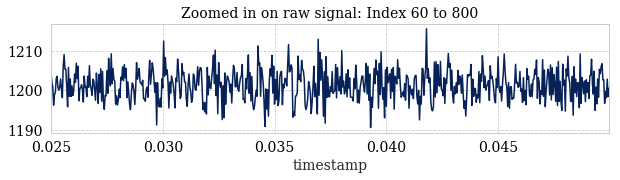

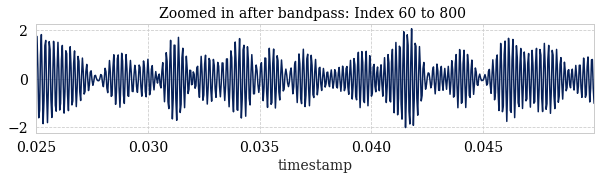

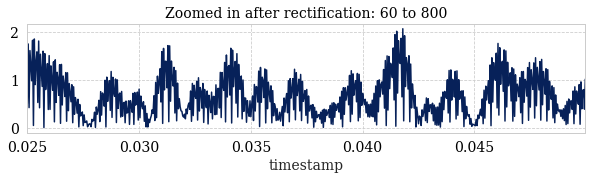

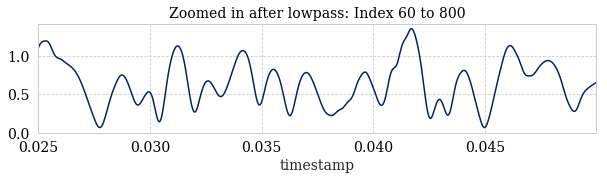

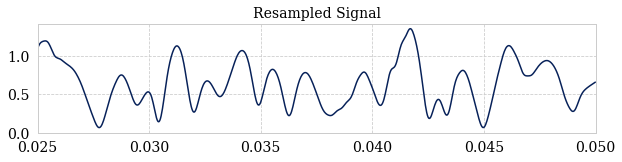

In [219]:
turbine_interval = 0
time_array = times_wt4[turbine_interval]
vibration_signal = vib_signal_wt4[turbine_interval]
peak_array = peak_array_wt04[turbine_interval]

lowcut = 5000
highcut = 6000
highcut_lowpass= 2000
steps = np.arange(0,len(times_wt4), 10)
for i,index in enumerate(steps):
    if i>0:
        break
    all_time_signals, all_fft_objects = perform_envelope_process(
        times_wt4[i],
        vib_signal_wt4[i],
        peak_array,
        'GbxHssRr',
        lowcut,
        highcut,
        highcut_lowpass,
        plot=True,
        resample_original=False,
        resample_last=True
    )
    # Do something with all_time_signals, all_fft_objects... Feature extraction/analysis of development

In [250]:
# Save to csv
path = '../../../../../MATLAB/Master/vibration_signal.csv'
vib_sig = all_time_signals[0]
np.savetxt(path, vib_sig, delimiter=',')


## Spectral Kutosis
We use a window of 1000 datapoints. This is because each shaft revolution contains about 1000 datapoints. <br>
This is another sentence
    

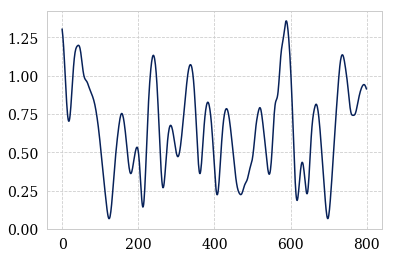

3.011841042869654

In [213]:
filtered_signal = all_time_signals[-1]
x = np.arange(0, len(filtered_signal))
plt.plot(x[0:800], filtered_signal[0:800])
plt.show()

kurtosis = scipy.stats.kurtosis(all_time_signals[0], fisher=False)
kurtosis
#x = np.arange(0, len(kurtosis))
#plt.plot(x[0:800], kurtosis[0:800])
#plt.show()

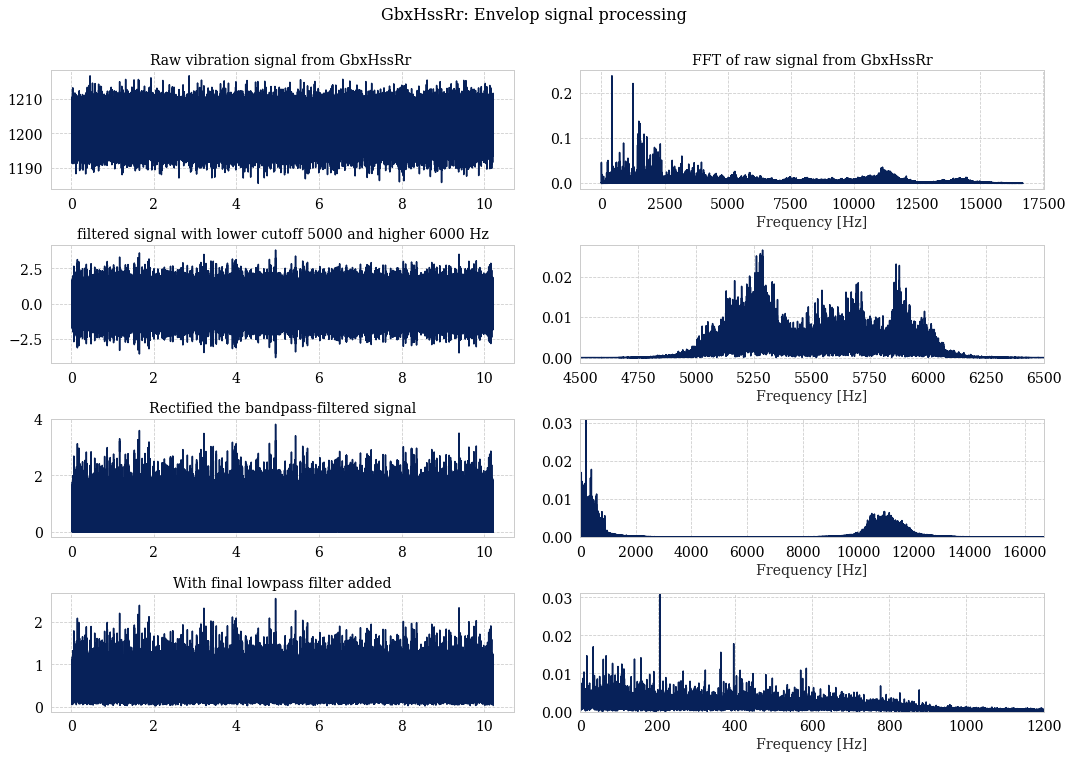

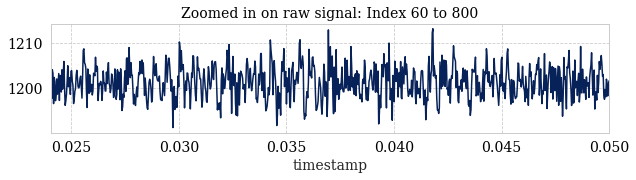

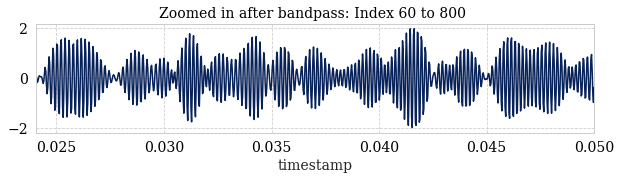

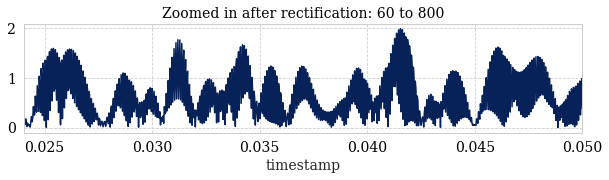

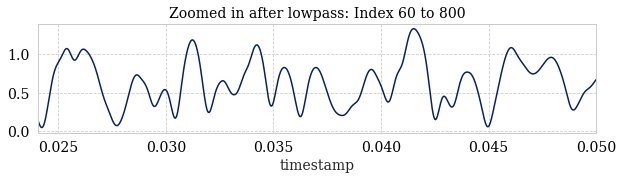

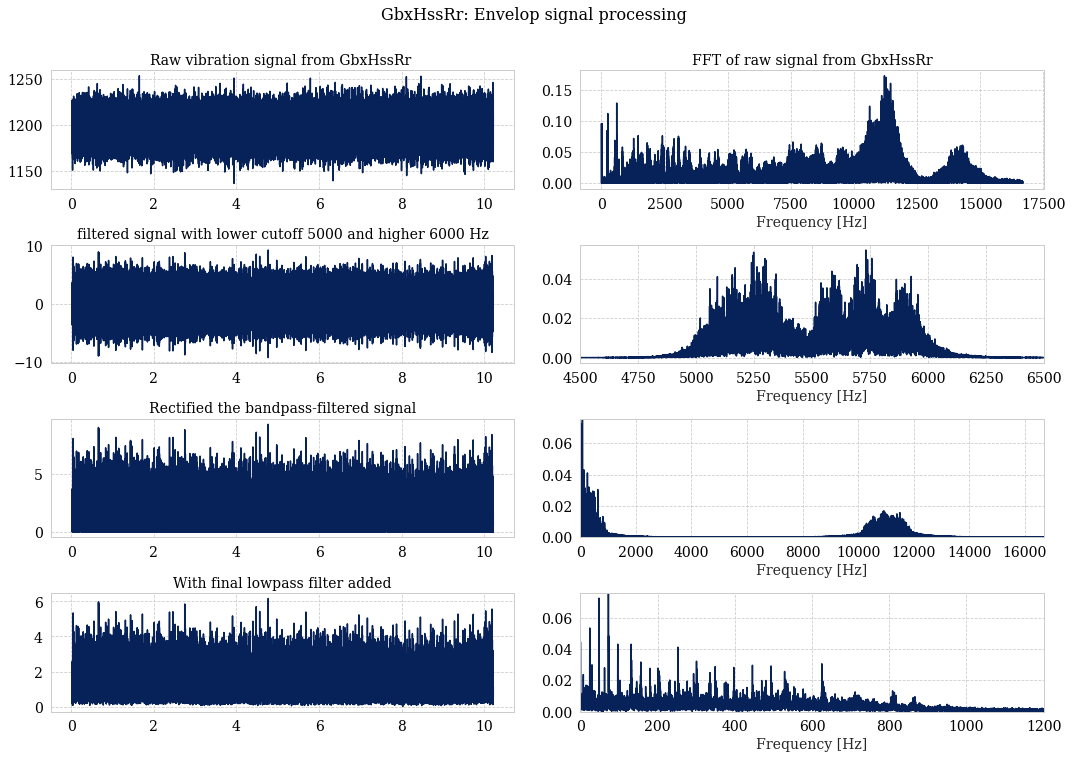

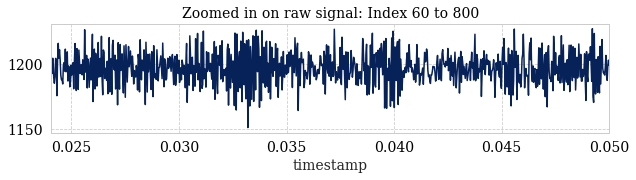

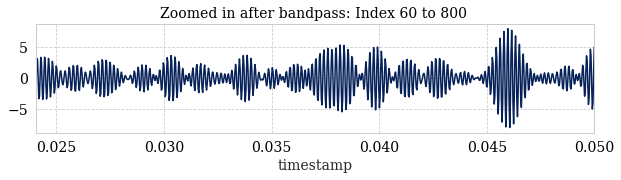

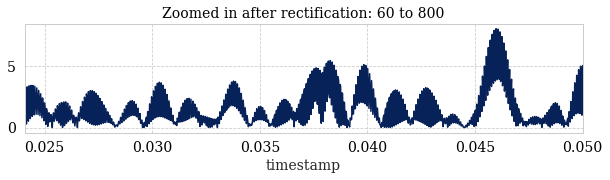

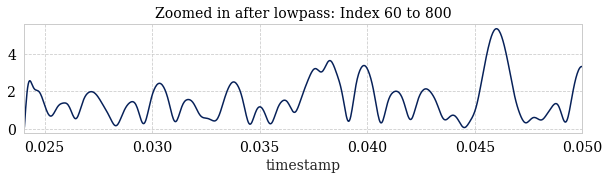

In [158]:
lowcut = 5000
highcut = 6000
steps = np.arange(0,len(times_wt4), 10)
for i,index in enumerate(steps):
    if i>1:
        break
    all_time_signals, all_fft_objects = perform_envelope_process(
        times_wt4[i],
        vib_signal_wt4[i],
        peak_array,
        'GbxHssRr',
        lowcut,
        highcut,
        plot=True,
        resample_original=True,
        resample_last=False
    )
    # Do something with all_time_signals, all_fft_objects... Feature extraction/analysis of development

### Note on filtering after highpass/lowpass: filtfilt vs. lfilt
filtfilt runs the filter forward and backward in time across the data, which produces a zero-phase response.  No frequencies are shifted in time, only attenuated.  Filtering backwards in time requires full knowledge of the future, though, so it can't be used in "online" real-life applications, only for offline processing of recordings of signals.  This would be best for something like smoothing of a financial or weather data series, for instance, where you don't want any phase shift.

# Implementation of Conventional Envelope process (HP + RECT + LP)

In [ ]:
def plot_real_enveloping_process(rows, cols, comp_name, raw_signal, processed_signals,timestamps, lowcut, highcut):
    fig, ax = plt.subplots(rows, cols,figsize=(15,10))
    fig.suptitle(f'{comp_name}: Envelop signal processing ',fontsize=16, y=1.05)

    # Raw signal
    ax[0,0].plot(timestamps,raw_signal)
    ax[0,0].set_title(f"Raw vibration signal from {COMPONENT_NAME} ")
    perform_fft(raw_signal,timestamps,ax[0,1])
    ax[0,1].set_xlabel("Frequency [Hz]")
    ax[0,1].set_title(f"Raw signal from {COMPONENT_NAME}")

    # Raw + HP
    ax[1,0].plot(timestamps, processed_signals[0])
    ax[1,0].set_title(f' Highpass filter applied with cutoff at {lowcut} Hz')
    perform_fft(processed_signals[0], timestamps, ax[1,1])
    ax[1,1].set_xlabel("Frequency [Hz]")
    ax[1,1].set_xlim(lowcut-500,highcut+500)
    
    # Raw + HP + abs
    ax[2,0].plot(timestamps, processed_signals[1])
    ax[2,0].set_title(f'Rectified the higpass filtered signal')
    perform_fft(processed_signals[1], timestamps, ax[2,1])
    ax[2,1].set_xlabel("Frequency [Hz]")
    ax[2,1].set_xlim(0,1000)   
    
    # Raw + HP + abs + LP
    ax[3,0].plot(timestamps, processed_signals[2])
    ax[3,0].set_title(f' Lowpass filter applied with cutoff at {highcut} Hz')
    perform_fft(processed_signals[2], timestamps, ax[3,1])
    ax[3,1].set_xlabel("Frequency [Hz]")
    # ax[3,1].set_xlim(0,1000)   
    
    plt.tight_layout()
    plt.margins(0)

In [ ]:
def perform_real_envelope_process(timestamps, interval_signal, fs, COMPONENT_NAME, lowcut,highcut,order = 5,):
    fs, _, _ ,_ =  get_sampling_freq(interval_signal,timestamps)
    
    highpass_filtered = butter_hp_filter(interval_signal,lowcut, fs, order=5)
    highpass_filtered_rect = abs(highpass_filtered)
    highpass_filtered_rect_lowpass = butter_lp_filter(highpass_filtered_rect, highcut, fs, order=5)
    
    processed_signals = [highpass_filtered,highpass_filtered_rect,highpass_filtered_rect_lowpass]
    # Plotting
    plot_real_enveloping_process(4,2,COMPONENT_NAME, interval_signal,processed_signals,timestamps,lowcut,highcut )
    
    # Plotting a selection of zoomed in plots
    df = pd.DataFrame(interval_signal)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[60:800].plot.line(x='timestamp',y=0,title="Raw signal: Zoomed in from point 60 to 800",legend=False)
    
    # Plotting a selection of zoomed in plots
    df = pd.DataFrame(highpass_filtered)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[60:800].plot.line(x='timestamp',y=0,title="HP filtered signal: Zoomed in from point 60 to 800",legend=False)
    
    df = pd.DataFrame(highpass_filtered_rect)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[100:800].plot.line(x='timestamp',y=0,title="HP + rectified filtered signal: Zoomed in from point 60 to 800",legend=False)
    
    df = pd.DataFrame(highpass_filtered_rect_lowpass)
    df['timestamp'] = timestamps
    # df.plot.hist(bins=2000)
    df.iloc[100:800].plot.line(x='timestamp',y=0,title="HP + rectified + LP filtered signal: Zoomed in on index 60 to 800",legend=False)
    return interval_signal, processed_signals

In [44]:
from scipy.signal import butter, lfilter,filtfilt

def butter_hp(lowcut, fs, order=5):
    nyq = 0.5 * fs
    w = lowcut / nyq
    b, a = butter(order, w, btype='highpass')
    return b, a

def butter_hp_filter(data, lowcut, fs, order=5):
    b, a = butter_hp(lowcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [45]:
# Lowpass

from scipy.signal import butter, lfilter,filtfilt

def butter_lp(highcut, fs, order=5):
    nyq = 0.5 * fs
    w = highcut / nyq
    b, a = butter(order, w, btype='lowpass')
    return b, a

def butter_lp_filter(data, highcut, fs, order=5):
    b, a = butter_lp(highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# Running functions

## lowcut = 4000, highcut = 60000

In [ ]:
lowcut = 4000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[0], vib_signal_wt4[0], fs,'GbxHssRr', lowcut, highcut)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[-1], vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[0], vib_signal_wt4[0], fs,'GbxHssRr', lowcut, highcut)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[-1], vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

df  = pd.DataFrame(processed_signals[-1])
df['Timestamps'] = times_wt4[-1]

In [ ]:
df[60:800].plot(y=0,x='Timestamps',title="testing",legend=False)

In [ ]:
lowcut = 5000
highcut =  6000
raw, processed_signals = perform_real_envelope_process(times_wt4[-1], vib_signal_wt4[-1], fs,'GbxHssRr', lowcut, highcut)

df  = pd.DataFrame(processed_signals[-1])
df['Timestamps'] = times_wt4[-1]